### makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length : how many characters do we take to predict the next one?
def build_dataset(words):
    X,Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)  
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X) 
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80% training set
Xdev, Ydev = build_dataset(words[n1:n2])  # 10% dev=validation set
Xte, Yte = build_dataset(words[n2:])      # 10% test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

seed_num = 2147483647
g = torch.Generator().manual_seed(seed_num)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,generator=g)
W2 = torch.randn((n_hidden,vocab_size), generator=g)
b2 = torch.randn(vocab_size,generator=g)

parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8465
  20000/ 200000: 2.5326
  30000/ 200000: 2.7456
  40000/ 200000: 2.1102
  50000/ 200000: 2.4841
  60000/ 200000: 2.4174
  70000/ 200000: 2.1213
  80000/ 200000: 2.3319
  90000/ 200000: 2.2887
 100000/ 200000: 1.9897
 110000/ 200000: 2.4673
 120000/ 200000: 2.0838
 130000/ 200000: 2.4918
 140000/ 200000: 2.2615
 150000/ 200000: 2.1656
 160000/ 200000: 2.0692
 170000/ 200000: 1.7849
 180000/ 200000: 2.0518
 190000/ 200000: 1.7405


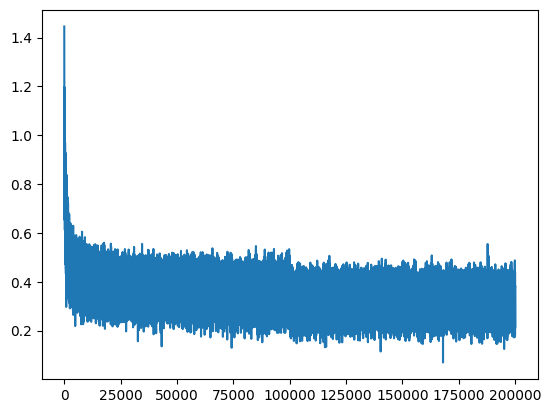

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1234049797058105
val 2.169248580932617


In [ ]:
# emd lookup table인 이유
C[5] == F.one_hot(torch.tensor(5), num_classes=vocab_size).float() @ C

C.shape # torch.Size([27, 10])

C[[5,6,7]]

tensor([[-0.9076,  0.4514, -0.0896, -0.9439,  0.2727,  0.4211,  0.4537, -0.3583,
         -0.6286,  0.0757],
        [ 0.8852, -0.5475, -1.7188, -1.4424,  0.7666, -0.3779,  1.5484,  2.7362,
         -0.9158,  0.4861],
        [-0.3037,  0.5863, -0.3471,  0.2158,  0.2101,  0.4904,  0.5042,  0.2936,
         -0.5448,  0.2392]], grad_fn=<IndexBackward0>)

In [15]:
C[5]

tensor([-0.9076,  0.4514, -0.0896, -0.9439,  0.2727,  0.4211,  0.4537, -0.3583,
        -0.6286,  0.0757], grad_fn=<SelectBackward0>)

In [16]:
C[6]

tensor([ 0.8852, -0.5475, -1.7188, -1.4424,  0.7666, -0.3779,  1.5484,  2.7362,
        -0.9158,  0.4861], grad_fn=<SelectBackward0>)

In [17]:
C[7]

tensor([-0.3037,  0.5863, -0.3471,  0.2158,  0.2101,  0.4904,  0.5042,  0.2936,
        -0.5448,  0.2392], grad_fn=<SelectBackward0>)

아래 코드는,
1. 모델이 예측한 확률 분포(Probability Distribution)을 얻어내고,
2. 그 분포로부터 가장 가능성 높은 것을 확률에 따라 뽑기(Sampling)하고,
3. 뽑힌 결과를 다음 예측의 입력으로 다시 사용하여, 한 글자씩 단어를 '조립'하는 과정과 같다. 

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(seed_num + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)  # probabilities of next character 
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
seel.
nah.
yal.
renyra.
endrael.
adeeroselin.
shy.
jenne.
elisson.
artelyn.
malkia.
noshubergahimies.
kendreelle.
jose.
casu.
zen.
der.
yarleyeks.


In [19]:
probs.shape

torch.Size([1, 27])